# Estudio de la evolución de la pandemia por el modelo ARIMA para la isla de Gran Canaria

En este estudio se analiza la evolución de la pandemia de COVID-19 en la isla de Gran Canaria y la influencia de factores como los atmosféricas en la evolución de dicha enfermedad. Para este fin se utiliza el modelo ARIMA tanto univariable como multivariable. 

El estudio se fragmenta en 4 partes:
* modelado univariable donde se emplea únicamente la variable objetivo.
* modelado multivariable empleando las variables pandémicas. Dichas variables son:
    * pcr_total: Número total de pruebas PCR realizadas.
    * Urg_cv: Ingresos en el servicio de urgencias por COVID19.
    * HPT_cv19: Ocupación del resto de camas para pacientes COVID.
    * CCR_cv19: Ocupación de las unidades críticas con respirador para pacientes COVID.
* modelado multivariable empleando las variables atmosféricas:
    * tmin: Temperatura mínima diaria.    
    * tmed: Temperatura media diaria.  
    * presMax: Presión máxima al nivel de la estación.   
* modelado multivariable con todas las variables.

In [1]:
# Carga inicial de librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:
def visualizar_STL(df):
    ''' Visualiza el gráfico STL con la descomposición en tendencia, estacionalidad y residuos de la serie temporal
    
    Args:
        df (DataFrame): DataFrame con los datos a realizar el estudio (DataFrame con una única columna que es la objetivo)
    '''
    stl = STL(df, period=12)
    res = stl.fit()
    
    fig = res.plot()

    
    plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m'))
    plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.MonthLocator(interval=1))

    plt.xticks(rotation=90)
    plt.show()
    

def visualizar_adf(df):
    ''' Visualiza el p-valor del estudio de Dickey-Fuller para determinar la estacionalidad de los datos
    
    Args:
        df (DataFrame): DataFrame con los datos a realizar el estudio (DataFrame con una única columna que es la objetivo)
    '''

    adf = adfuller(df)
    print("ADF p-value:" + str(adf[1]))
    

def visualizar_acf(df, n_lags):
    ''' Método que visualiza un gráfico con la autocorrelación de los datos con los n rezagos anteriores
    
    Args:
        df (DataFrame): Dataframe con los datos a realizar ele studio de autocorrelación parcial
        n_lags (integer): Número de rezagos a analizar
    '''
    plt.figure(figsize=(16, 10))
    plot_acf(df, lags=n_lags)
    plt.xlabel('Rezagos')
    plt.ylabel('Autocorrelación')
    plt.title('ACF')
    plt.gca().set_facecolor('lightgrey')
    plt.grid(True, linestyle='--', linewidth=0.5, color='white')
    plt.show()
    
def visualizar_pacf(df, n_lags):
    ''' Método que visualiza un gráfico con la autocorrelación parcial de los datos con los n rezagos anteriores
    
    Args:
        df (DataFrame): Dataframe con los datos a realizar ele studio de autocorrelación parcial
        n_lags (integer): Número de rezagos a analizar
    '''
    plt.figure(figsize=(16, 6))
    plot_pacf(df, lags=n_lags)
    plt.xlabel('Rezagos')
    plt.ylabel('Autocorrelación parcial')
    plt.title('PACF')
    plt.gca().set_facecolor('lightgrey')
    plt.grid(True, linestyle='--', linewidth=0.5, color='white')
    plt.show()
    
    
def visualizar_dif_pred_test(test, pred, variable, tit):
    ''' Método que visualiza un gráfico con la comparativa entre el número de casos reales y los predichos
    
    Args:
        test (DataFrame): Valores reales del conjunto de test
        pred (Serie): Valores predichos por el modelo
        variable(string): Variable objetivo
        tit(string): título del gráfico
    '''
    
    plt.figure(figsize=(10, 6))

    if variable != '':
        plt.plot(test.index, test[variable], label='Test', color='green')
    else:
        plt.plot(test.index, test, label='Test', color='green')
    plt.plot(test.index, pred, label='Predicción', color='orange')

    plt.gca().set_facecolor('lightgrey')
    plt.grid(True, linestyle='--', linewidth=0.5, color='white')
    plt.xticks(rotation=60)
    plt.legend()
    plt.title(tit)
    plt.xlabel('Fecha')
    plt.ylabel('Número de casos de COVID')
    plt.show()
    
def visualizar_historico(train, test, pred, variable, dias_historico, tit, color, dif):
    ''' Método que visualiza un gráfico con la comparativa entre el número de casos reales y los predichos
        y muestra el historico de casos en función del número de días que indiquemos que muestre
    
    Args:
        train (DataFrame): Conjunto de datos de entrenamiento
        test (DataFrame): Valores reales del conjunto de test
        pred (Serie): Valores predichos por el modelo
        variable (string): Variable objetivo
        dias_historico (integer): días hacia atrás a mostrar del historico
        tit (string): título del gráfico
        color (string): color de la isla para visualizar
    '''
    train_s = train.iloc[len(train) - dias_historico:]
    
    plt.figure(figsize=(10, 6))

    if variable != '':
        plt.plot(train_s.index, train_s[variable], label='Train', color=color)
        plt.plot(test.index, test[variable], label='Test', color='green')
    else:
        plt.plot(train_s.index, train_s, label='Train', color=color)
        plt.plot(test.index, test, label='Test', color='green')
    
    plt.plot(test.index, pred, label='Predicción', color='orange')
    plt.bar(test.index, dif, width=0.5, color='black', alpha=0.2, align='edge', label='Diferencia')
    
    
    plt.xticks(np.arange(0, len(train_s.index)  + len(test.index), step=5),   train_s.index.union(test.index)[::5], rotation=70)
    plt.gca().set_facecolor('lightgrey')
    plt.grid(True, linestyle='--', linewidth=0.5, color='white')
    plt.legend()
    plt.title(tit)
    plt.xlabel('Fecha')
    plt.ylabel('Número de casos de COVID')
    plt.show()
    
    
def obtener_errores(y_true, y_pred):
    ''' Método que devuelvo los errores:
            * MAE: Error absoluto medio
            * MSE: Error cuadrático medio
            * RMSE: Raíz del error cuadrático medio
    
    Args:
        y_true (Serie): Valores reales del conjunto de test
        y_pred (Serie): Valores predichos por el modelo
    Return:
        mae(float): Error absoluto medio
        mse(float): Error cuadrático medio
        rmse(float): Raíz del error cuadrático medio
    '''
    
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    
    return mae, mse, rmse

def visualizar_bic_aic(modelo):
    ''' Visualiza los datos de BIC (Criterio de Información Bayesiano) y  AIC (Criterio de Información de Akaike)
    
    Args:
        modelo (ARIMA): modelo ARIMA entrenado
    '''
    
    bic = modelo.bic
    aic = modelo.aic

    print("BIC del modelo ARIMA:", bic)
    print("AIC del modelo ARIMA:", aic)
    
def visualizar_resultados_texto(y_test, y_pred, variable):
    ''' Método que visualiza por pantalla en formato de texto el número de csaos reales y los predichos por el algoritmo
    
    Args:
        y_test (Serie): Valores reales del conjunto de test
        y_pred (Serie): Valores predichos por el modelo
        variable(string): Variable objetivo
    '''
    fechas = y_test.index
    for i in range(len(y_test)):
        if variable != '':
            valor_test = y_test[variable][i]
        else:
            valor_test = y_test[i] 
        print(str(fechas[i]) + ': número de casos reales ' + str(valor_test) + ', número de casos predichos ' + str(y_pred[i]))
        
def obtener_df_diferencias(test, pred, variable):
    ''' Obtiene la diferencia entre los valores de test y los predichos
    
    Args:
        test (Serie): Valores reales del conjunto de test
        pred (Serie): Valores predichos por el modelo
        variable(string): Variable objetivo
    '''
    df_result = test.copy()
    if variable != '':
        df_result = df_result[variable]
        df_result = df_result.to_frame()
    else:
        df_result = df_result.to_frame()
    df_result['pred'] = 0
    df_result['dif'] = 0

    for i in range(len(df_result)):
        df_result.iloc[i, df_result.columns.get_loc('pred')] = pred[i]
        df_result.iloc[i, df_result.columns.get_loc('dif')] = df_result['numero_casos'][i] - pred[i]
        
    return df_result

Inicialmente cargamos los datos del fichero con los datos procesados anteriormente y obtenemos los datos únicamente para la isla de Tenerife.

In [3]:
# Cargamos los datos de las estaciones de cada una de las islas
datos_islas = pd.read_csv('../data/Final/datos_reduc_final.csv', header=0)

# Obtenemos los datos de la isla a la que se le va a realizar el estudio
datos_GranCanaria = datos_islas[datos_islas['isla'] == 'GRAN CANARIA'].copy()


datos_GranCanaria = datos_GranCanaria.sort_values(by='fecha')   # Ordenamos por fecha por si los datos devueltos no estuvieran en orden
datos_GranCanaria.set_index('fecha', inplace=True)           # Añadimos como índice de los datos la fecha

In [4]:
# Variables globales a utilizar en todo el proceso

objetivo = 'numero_casos' # Variable objetivo
n_dias = 10               # Numero de días correspondiente al conjunto de TEST
n_dias_train_vis = 100    # Número de días del conjunto de train a visualizar en el conjunto de train
color_isla = 'sienna'       # Color de la isla en las visualizaciones
isla = 'Gran Canaria'         # Nombre de la isla para las visualizaciones    

variables_covid = ['pcr_total', 'Urg_cv', 'HPT_cv19', 'CCR_cv19']   # Atributos para el análisis de las variables pandémicas
variables_atm = ['tmin', 'tmed', 'presMax']                         # Atributos para el análisis de las variables atmosféricas
variables = ['pcr_total', 'Urg_cv', 'HPT_cv19', 'CCR_cv19','tmin', 'tmed', 'presMax'] # Atributos para el análisis de todas las variables

Separamos los datos en función de las variables a emplear en cada uno de los estudios que se van a realizar.

In [5]:
# Obtenemos los conjuntos de datos para cada modelo con las variables necesarias para cada uno de ellos

datos_GranCanaria_arima_uni = datos_GranCanaria[objetivo]               # Datos modelo Univariable
datos_GranCanaria_arima_mult_covid = datos_GranCanaria[[objetivo] + variables_covid] # Datos modelo Multivariable con datos pandémicos
datos_GranCanaria_arima_mult_atm = datos_GranCanaria[[objetivo] + variables_atm]     # Datos modelo Multivariable con datos atmosféricos
datos_GranCanaria_arima_total = datos_GranCanaria.copy()                # Datos modelo Multivariable con todos los datos

Descomponemos la serie temporal en sus tres componentes principales: tendencia, estacionalidad y residuos.

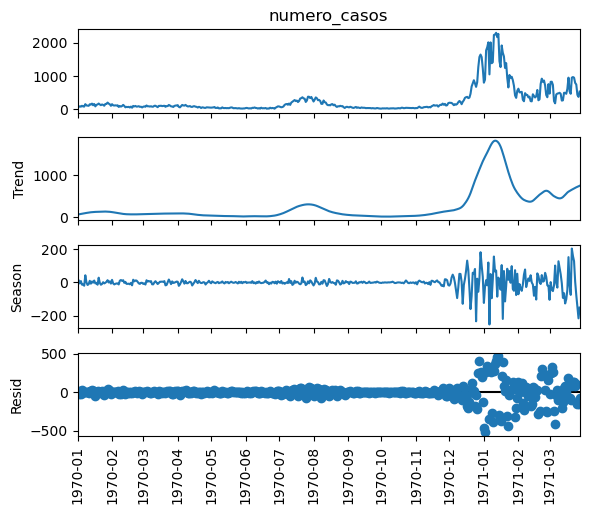

In [6]:
visualizar_STL(datos_GranCanaria_arima_uni)

Para aplicar el modelo de ARIMA debemos de investigar los valores óptimos iniciales para los parámetros p,d,q los cuales equivalen a Autorregresivo (AR), Integrado (I), Promedio Móvil (MA). Para obtener el parámetro óptimo realizaremos diferentes estudios: 
* Para el parámetro d realizamos la prueba de Dickey-Fuller para determinar la estacionalidad de los datos de forma que si los datos son no estacionarios debemos de aplicar diferenciaciones hasta obtener una serie temporal, siendo este número de diferenciaciones el valor de d. Si la serie temporal ya era estacionaria el valor será 0.
* Para el parámetro q emplearemos la función de autocorrelación donde se estudia la correlación de los datos de la serie temporal con sus rezagos, de forma que el rezago anterior a que entre en la zona de confianza equivaldrá a nuestro parámetro óptimo.
* Para el parámetro p utilizamos la función de autocorrelación parcial que al igual que el parámetro anterior el rezago anterior a aquel que entre en la zona de confianza será el valor inicial ópti.
io.


En primer lugar realizamos la prueba de Dickey-Fuller para verificar si la serie temporal es estacionaria.

In [7]:
visualizar_adf(datos_GranCanaria_arima_uni)

ADF p-value:0.05546091881926496


In [8]:
datos_GranCanaria_arima_uni_1d = datos_GranCanaria_arima_uni.diff().dropna()
visualizar_adf(datos_GranCanaria_arima_uni_1d)

ADF p-value:0.00014152243300611368


Para la isla de Gran Canaria es necesaria una diferenciación para poder obtener una serie temporal estacionaria por lo que el parámetro d es 1.

Una vez ajustado el parámetro d realizamos un análisis de la Función de autocorrelación (ACF) para medir la correlación de la serie temporal y sus valores rezagados para determinar el valor de q.

<Figure size 1600x1000 with 0 Axes>

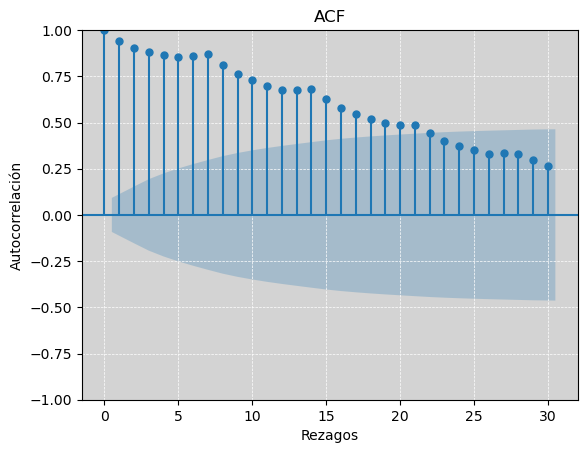

In [9]:
visualizar_acf(datos_GranCanaria_arima_uni, 30)

Por último realizamos un análisis de la Función e Autocorrelación Parcial (PACF) para determinar el valor de p.

<Figure size 1600x600 with 0 Axes>

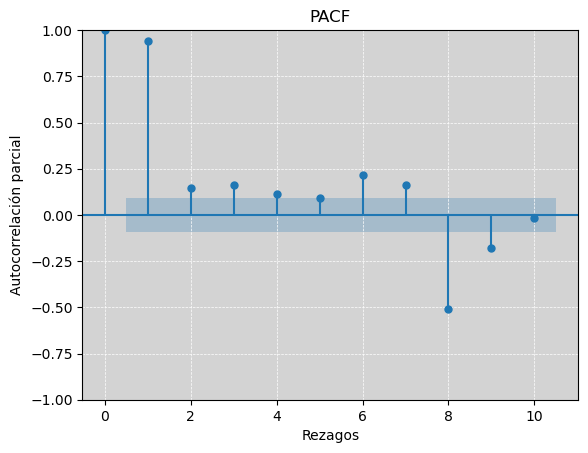

In [10]:
visualizar_pacf(datos_GranCanaria_arima_uni, 10)

In [11]:
# Parámetros del modelo ARIMA
p = 2   # Parámetro Autorregresivo (AR)
d = 1   # Parámetro Integrado (I)
q = 3   # Parámetro Promedio Movil (MA)

# Modelo ARIMA univariable

Realizamos el análisis con los datos únicamente de la variable objetivo obteniendo un modelo ARIMA univariable.

Dividimos los datos en conjunto de entrenamiento y test. Para el conjunto de datos de test se emplean los últimos 10 días de la serie temporal y para el conjunto de entrenamiento el resto de datos.

In [12]:
# Conjuntos de entrenamiento y test
train = datos_GranCanaria_arima_uni.iloc[:len(datos_GranCanaria_arima_uni) - n_dias]
test =  datos_GranCanaria_arima_uni.iloc[len(datos_GranCanaria_arima_uni) - n_dias:]

Entrenamos el modelo con los parámetros óptimos obtenidos.

In [13]:
#order=(p,d,q)

arima_GranCanaria = ARIMA(endog=train, order=(p, d, q), freq = 'D')
modelo_arima_GranCanaria = arima_GranCanaria.fit()

C:\Users\jalon\anaconda3\envs\tfm\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\jalon\anaconda3\envs\tfm\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\jalon\anaconda3\envs\tfm\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Como medida de validación del modelo visualizamos los resuldatos del criterio de información Bayesiano (BIC) y el criterio de información Akaike(AIC).

In [14]:
visualizar_bic_aic(modelo_arima_GranCanaria)

BIC del modelo ARIMA: 5563.969521904299
AIC del modelo ARIMA: 5539.435252651618


Evaluamos los residuos del modelo mediante la función de autocorrelación para determinar la correlación entre los residuos, si existe una fuerte correlación entre ellos implicaría que el modelo no está bien ajustado.

<Figure size 1600x1000 with 0 Axes>

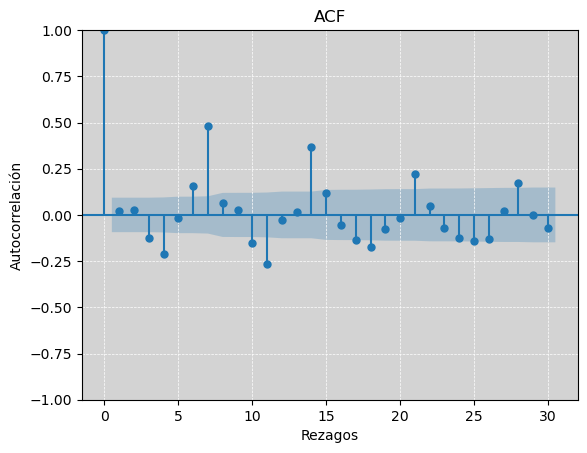

In [15]:
visualizar_acf(modelo_arima_GranCanaria.resid, 30)

Realizamos la predicción de las 10 últimas fechas de la serie temporal.

In [16]:
pred = modelo_arima_GranCanaria.forecast(steps=10)
#pred = model_arima_GranCanaria.predict(start=test.index[0], end=test.index[-1])

Visualizamos una comparación entre los valores reales y los valores predichos.

In [17]:
visualizar_resultados_texto(test, pred, '')

2022-03-19: número de casos reales 533, número de casos predichos 837.0692285264405
2022-03-20: número de casos reales 461, número de casos predichos 749.7086615053072
2022-03-21: número de casos reales 948, número de casos predichos 754.6968320865554
2022-03-22: número de casos reales 966, número de casos predichos 821.0344939886547
2022-03-23: número de casos reales 948, número de casos predichos 777.6537068343689
2022-03-24: número de casos reales 790, número de casos predichos 750.8095635644324
2022-03-25: número de casos reales 741, número de casos predichos 801.1761894798456
2022-03-26: número de casos reales 428, número de casos predichos 792.5389984326522
2022-03-27: número de casos reales 368, número de casos predichos 757.7167525068452
2022-03-28: número de casos reales 528, número de casos predichos 785.2630032804454


C:\Users\jalon\AppData\Local\Temp\ipykernel_7056\4176007000.py:176: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  valor_test = y_test[i]
C:\Users\jalon\AppData\Local\Temp\ipykernel_7056\4176007000.py:177: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(str(fechas[i]) + ': número de casos reales ' + str(valor_test) + ', número de casos predichos ' + str(y_pred[i]))


Graficamos la diferencia entre los valores de test y los predichos.

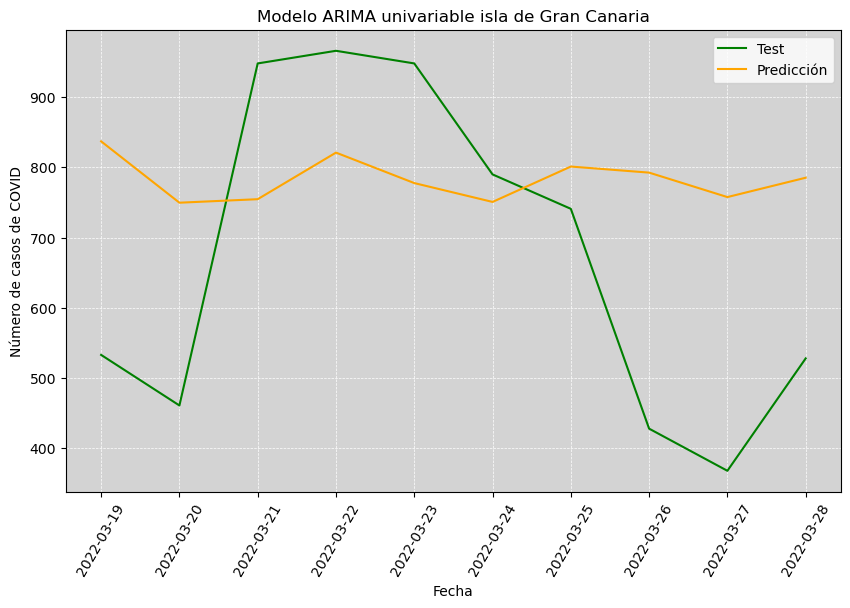

In [18]:
# Título para las visualizaciones
tit = 'Modelo ARIMA univariable isla de ' + isla
visualizar_dif_pred_test(test, pred, '', tit)

Calculamos la diferencia entre los valores reales y los valores predichos.

In [19]:
df_result = obtener_df_diferencias(test, pred, '')
df_result

C:\Users\jalon\AppData\Local\Temp\ipykernel_7056\4176007000.py:197: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df_result.iloc[i, df_result.columns.get_loc('pred')] = pred[i]
C:\Users\jalon\AppData\Local\Temp\ipykernel_7056\4176007000.py:197: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '837.0692285264405' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_result.iloc[i, df_result.columns.get_loc('pred')] = pred[i]
C:\Users\jalon\AppData\Local\Temp\ipykernel_7056\4176007000.py:198: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value 

,numero_casos,pred,dif
fecha,,,
2022-03-19,533,837.069229,-304.069229
2022-03-20,461,749.708662,-288.708662
2022-03-21,948,754.696832,193.303168
2022-03-22,966,821.034494,144.965506
2022-03-23,948,777.653707,170.346293
2022-03-24,790,750.809564,39.190436
2022-03-25,741,801.176189,-60.176189
2022-03-26,428,792.538998,-364.538998
2022-03-27,368,757.716753,-389.716753


Por último, graficamos una parte del histórico de los datos de entrenamiento junto con los resultados del modelo ARIMA y los valores predichos. A su vez mostramos un histograma con la diferencia entre dichos valores.

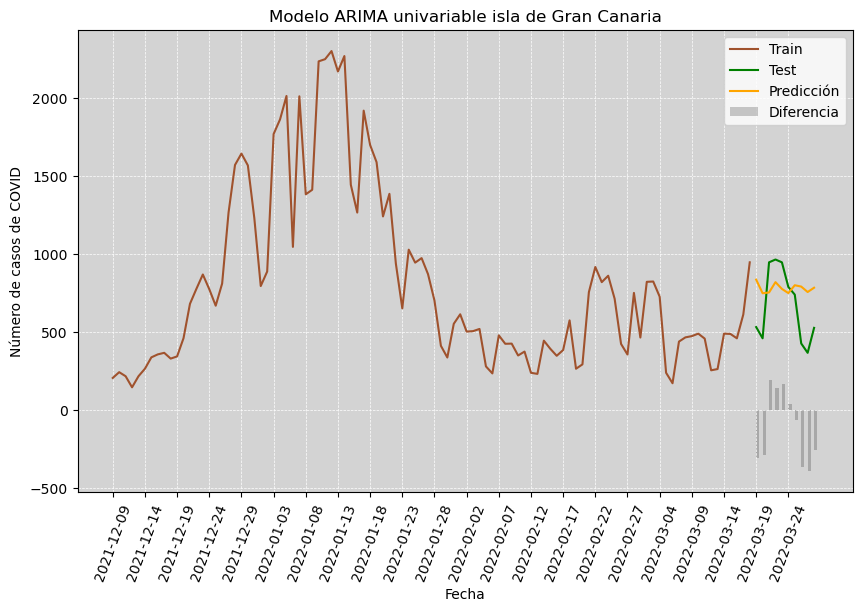

In [20]:
visualizar_historico(train, test, pred, '', n_dias_train_vis, tit, color_isla, df_result['dif'])

Para la evaluación del modelo se utilizarán las siguientes estimadores:
* MAE: Error absoluto medio
* MSE: Error cuadrático medio 
* RMSE: Raíz del error cuadrático medio 

In [21]:
mae, mse, rmse = obtener_errores(test, pred)

print("Error cuadrático medio (MSE) del modelo: " + str(mse))
print("Error absoluto medio (MAE) del modelo: " + str(mae))
print("Raíz del error cuadrático medio (RMSE) del modelo: " + str(rmse))

Error cuadrático medio (MSE) del modelo: 61931.89047265825
Error absoluto medio (MAE) del modelo: 221.22782372575247
Raíz del error cuadrático medio (RMSE) del modelo: 248.86118715592886


# Modelo ARIMA multivariable con variables de pandemia

Realizamos el análisis con los datos pandémicos obteniendo un modelo ARIMA multivariable en base a dichas variables.

Dividimos los datos en conjunto de entrenamiento y test. Para el conjunto de datos de test se emplean los últimos 10 días de la serie temporal y para el conjunto de entrenamiento el resto de datos.

In [22]:
train = datos_GranCanaria_arima_mult_covid.iloc[:len(datos_GranCanaria_arima_mult_covid) - n_dias]
test =  datos_GranCanaria_arima_mult_covid.iloc[len(datos_GranCanaria_arima_mult_covid) - n_dias:]

Entrenamos el modelo con los parámetros óptimos obtenidos.

In [23]:
#order=(p,d,q)
# Parámetros del modelo ARIMA

arima_GranCanaria = ARIMA(endog=train[objetivo],exog=train[variables_covid], order=(p, d, q), freq = 'D')
modelo_arima_GranCanaria = arima_GranCanaria.fit()

C:\Users\jalon\anaconda3\envs\tfm\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\jalon\anaconda3\envs\tfm\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\jalon\anaconda3\envs\tfm\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\jalon\anaconda3\envs\tfm\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Visualizamos los resultados de los criterios BIC y AIC.

In [24]:
visualizar_bic_aic(modelo_arima_GranCanaria)

BIC del modelo ARIMA: 5237.013705748876
AIC del modelo ARIMA: 5196.123256994408


Evaluamos los residuos del modelo mediante la función de autocorrelación para determinar la correlación entre los residuos, si existe una fuerte correlación entre ellos implicaría que el modelo no está bien ajustado.

<Figure size 1600x1000 with 0 Axes>

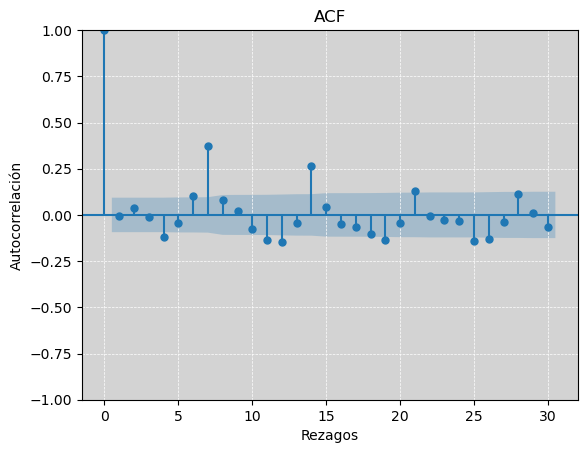

In [25]:
visualizar_acf(modelo_arima_GranCanaria.resid, 30)

Realizamos la predicción de las 10 últimas fechas de la serie temporal.

In [26]:
pred = modelo_arima_GranCanaria.forecast(steps=10, exog=test[variables_covid])

Visualizamos una comparación entre los valores reales y los valores predichos.

In [27]:
visualizar_resultados_texto(test, pred, objetivo)

2022-03-19: número de casos reales 533, número de casos predichos 693.8309154744882
2022-03-20: número de casos reales 461, número de casos predichos 574.9920082129036
2022-03-21: número de casos reales 948, número de casos predichos 872.2167744630203
2022-03-22: número de casos reales 966, número de casos predichos 916.7945653621487
2022-03-23: número de casos reales 948, número de casos predichos 870.4991644218114
2022-03-24: número de casos reales 790, número de casos predichos 750.4832083715705
2022-03-25: número de casos reales 741, número de casos predichos 775.9581290374408
2022-03-26: número de casos reales 428, número de casos predichos 617.8919462118097
2022-03-27: número de casos reales 368, número de casos predichos 568.5795172608769
2022-03-28: número de casos reales 528, número de casos predichos 731.4817364344328


C:\Users\jalon\AppData\Local\Temp\ipykernel_7056\4176007000.py:174: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  valor_test = y_test[variable][i]
C:\Users\jalon\AppData\Local\Temp\ipykernel_7056\4176007000.py:177: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(str(fechas[i]) + ': número de casos reales ' + str(valor_test) + ', número de casos predichos ' + str(y_pred[i]))


Graficamos la diferencia entre los valores de test y los predichos.

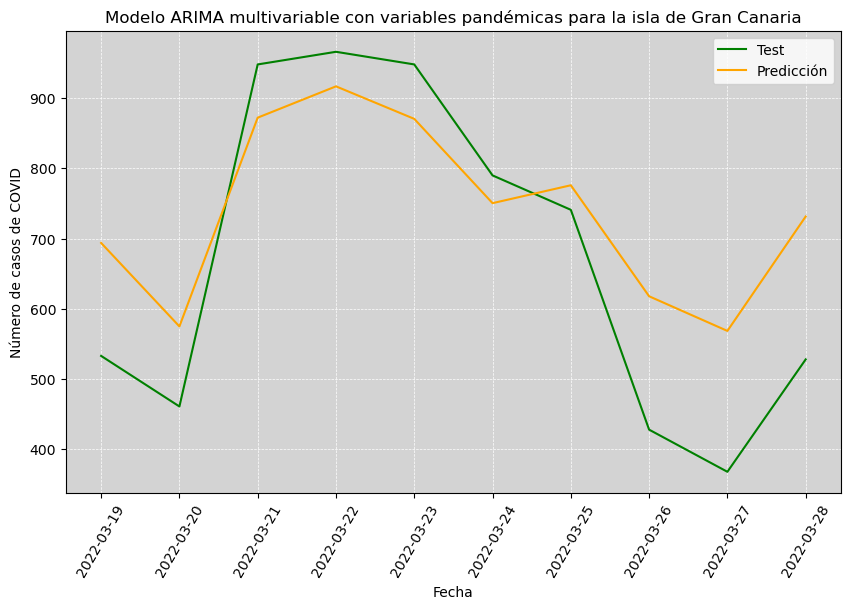

In [28]:
tit = 'Modelo ARIMA multivariable con variables pandémicas para la isla de ' + isla
visualizar_dif_pred_test(test, pred, objetivo, tit)

Calculamos la diferencia entre los valores reales y los valores predichos.

In [29]:
df_result = obtener_df_diferencias(test, pred, objetivo)
df_result

C:\Users\jalon\AppData\Local\Temp\ipykernel_7056\4176007000.py:197: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df_result.iloc[i, df_result.columns.get_loc('pred')] = pred[i]
C:\Users\jalon\AppData\Local\Temp\ipykernel_7056\4176007000.py:197: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '693.8309154744882' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_result.iloc[i, df_result.columns.get_loc('pred')] = pred[i]
C:\Users\jalon\AppData\Local\Temp\ipykernel_7056\4176007000.py:198: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value 

,numero_casos,pred,dif
fecha,,,
2022-03-19,533,693.830915,-160.830915
2022-03-20,461,574.992008,-113.992008
2022-03-21,948,872.216774,75.783226
2022-03-22,966,916.794565,49.205435
2022-03-23,948,870.499164,77.500836
2022-03-24,790,750.483208,39.516792
2022-03-25,741,775.958129,-34.958129
2022-03-26,428,617.891946,-189.891946
2022-03-27,368,568.579517,-200.579517


Por último, graficamos una parte del histórico de los datos de entrenamiento junto con los resultados del modelo ARIMA y los valores predichos. A su vez mostramos un histograma con la diferencia entre dichos valores.

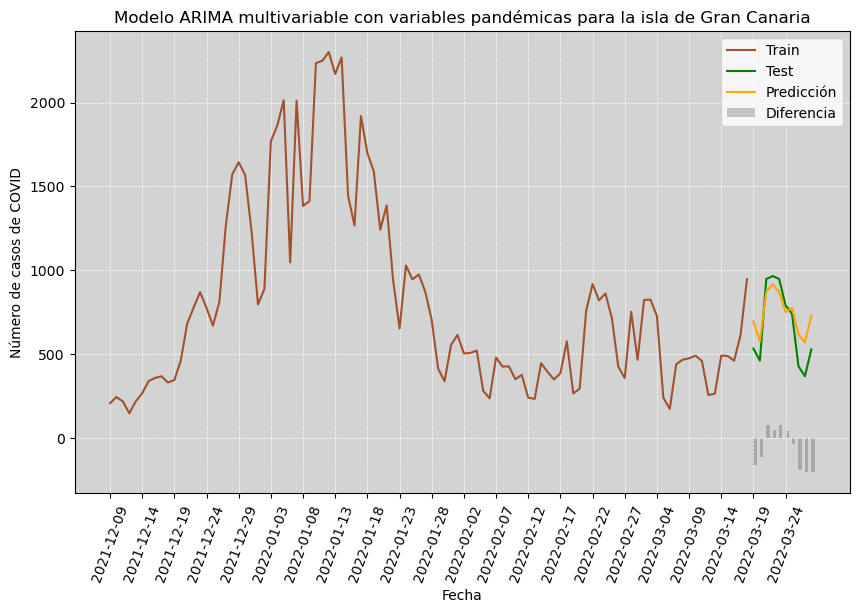

In [30]:
visualizar_historico(train, test, pred, objetivo, n_dias_train_vis, tit, color_isla, df_result['dif'])

Evaluamos los resultados con las métricas comentadas anteriormente.

In [31]:
mae, mse, rmse = obtener_errores(test[objetivo], pred)

print("Error cuadrático medio (MSE) del modelo: " + str(mse))
print("Error absoluto medio (MAE) del modelo: " + str(mae))
print("Raíz del error cuadrático medio (RMSE) del modelo: " + str(rmse))

Error cuadrático medio (MSE) del modelo: 17351.09715442689
Error absoluto medio (MAE) del modelo: 114.5740540013401
Raíz del error cuadrático medio (RMSE) del modelo: 131.7235633986072


# Modelo ARIMA multivariable con variables atmosféricas

Realizamos el análisis con los datos atmosféricos obteniendo un modelo ARIMA multivariable en base a dichas variables.

Dividimos los datos en conjunto de entrenamiento y test. Para el conjunto de datos de test se emplean los últimos 10 días de la serie temporal y para el conjunto de entrenamiento el resto de datos.

In [32]:
train = datos_GranCanaria_arima_mult_atm.iloc[:len(datos_GranCanaria_arima_mult_atm) - n_dias]
test =  datos_GranCanaria_arima_mult_atm.iloc[len(datos_GranCanaria_arima_mult_atm) - n_dias:]

Entrenamos el modelo con los parámetros óptimos obtenidos.

In [33]:
arima_GranCanaria = ARIMA(endog=train[objetivo],exog=train[variables_atm], order=(p, d, q), freq = 'D')
modelo_arima_GranCanaria = arima_GranCanaria.fit()

C:\Users\jalon\anaconda3\envs\tfm\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\jalon\anaconda3\envs\tfm\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\jalon\anaconda3\envs\tfm\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\jalon\anaconda3\envs\tfm\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Visualizamos los resultados de los criterios BIC y AIC.

In [34]:
visualizar_bic_aic(modelo_arima_GranCanaria)

BIC del modelo ARIMA: 5582.136338022246
AIC del modelo ARIMA: 5545.334934143224


Evaluamos los residuos del modelo con la función de autocorrelación.

<Figure size 1600x1000 with 0 Axes>

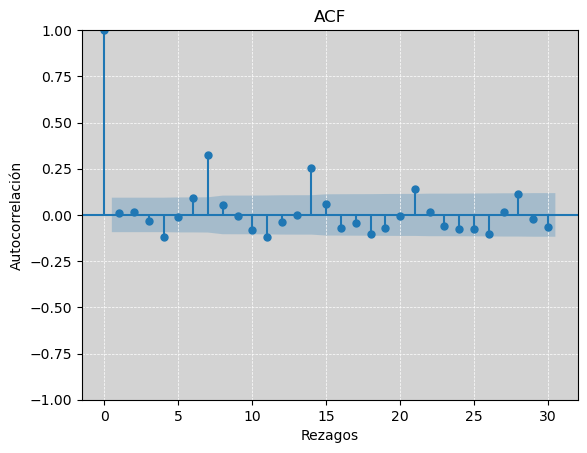

In [35]:
visualizar_acf(modelo_arima_GranCanaria.resid, 30)

Realizamos la predicción de las 10 últimas fechas de la serie temporal.

In [36]:
pred = modelo_arima_GranCanaria.forecast(steps=10, exog=test[variables_atm])

Visualizamos una comparación entre los valores reales y los valores predichos.

In [37]:
visualizar_resultados_texto(test, pred, objetivo)

2022-03-19: número de casos reales 533, número de casos predichos 815.8182903396237
2022-03-20: número de casos reales 461, número de casos predichos 715.9951047785012
2022-03-21: número de casos reales 948, número de casos predichos 732.0065503384487
2022-03-22: número de casos reales 966, número de casos predichos 782.0574139553128
2022-03-23: número de casos reales 948, número de casos predichos 740.3029049172553
2022-03-24: número de casos reales 790, número de casos predichos 742.9179493092568
2022-03-25: número de casos reales 741, número de casos predichos 773.657363272192
2022-03-26: número de casos reales 428, número de casos predichos 760.3273663968025
2022-03-27: número de casos reales 368, número de casos predichos 762.9305270397163
2022-03-28: número de casos reales 528, número de casos predichos 774.458314956039


C:\Users\jalon\AppData\Local\Temp\ipykernel_7056\4176007000.py:174: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  valor_test = y_test[variable][i]
C:\Users\jalon\AppData\Local\Temp\ipykernel_7056\4176007000.py:177: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(str(fechas[i]) + ': número de casos reales ' + str(valor_test) + ', número de casos predichos ' + str(y_pred[i]))


Graficamos la diferencia entre los valores de test y los predichos.

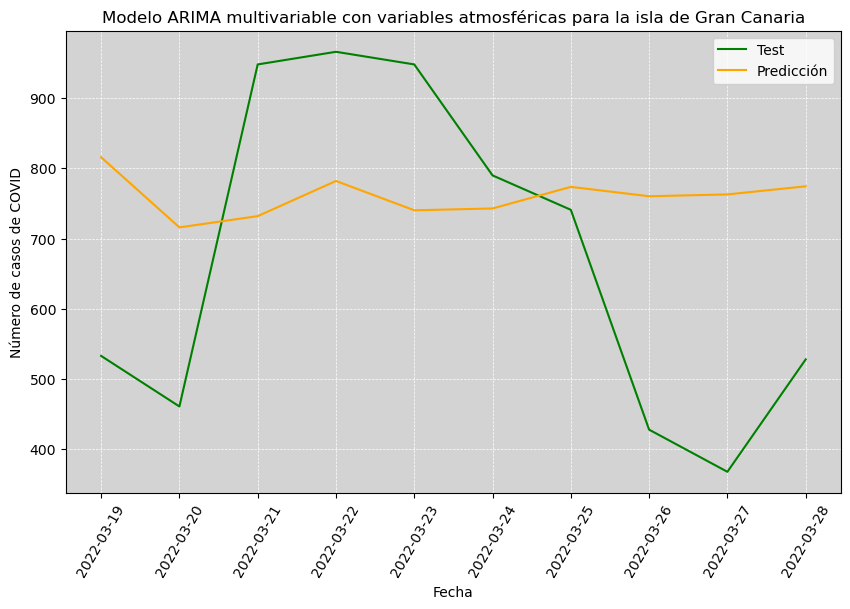

In [38]:
tit = 'Modelo ARIMA multivariable con variables atmosféricas para la isla de ' + isla

visualizar_dif_pred_test(test, pred, objetivo, tit)

Calculamos la diferencia entre los valores reales y los valores predichos.

In [39]:
df_result = obtener_df_diferencias(test, pred, objetivo)
df_result

C:\Users\jalon\AppData\Local\Temp\ipykernel_7056\4176007000.py:197: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df_result.iloc[i, df_result.columns.get_loc('pred')] = pred[i]
C:\Users\jalon\AppData\Local\Temp\ipykernel_7056\4176007000.py:197: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '815.8182903396237' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_result.iloc[i, df_result.columns.get_loc('pred')] = pred[i]
C:\Users\jalon\AppData\Local\Temp\ipykernel_7056\4176007000.py:198: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value 

,numero_casos,pred,dif
fecha,,,
2022-03-19,533,815.818290,-282.818290
2022-03-20,461,715.995105,-254.995105
2022-03-21,948,732.006550,215.993450
2022-03-22,966,782.057414,183.942586
2022-03-23,948,740.302905,207.697095
2022-03-24,790,742.917949,47.082051
2022-03-25,741,773.657363,-32.657363
2022-03-26,428,760.327366,-332.327366
2022-03-27,368,762.930527,-394.930527


Por último, graficamos una parte del histórico de los datos de entrenamiento junto con los resultados del modelo ARIMA y los valores predichos. A su vez mostramos un histograma con la diferencia entre dichos valores.

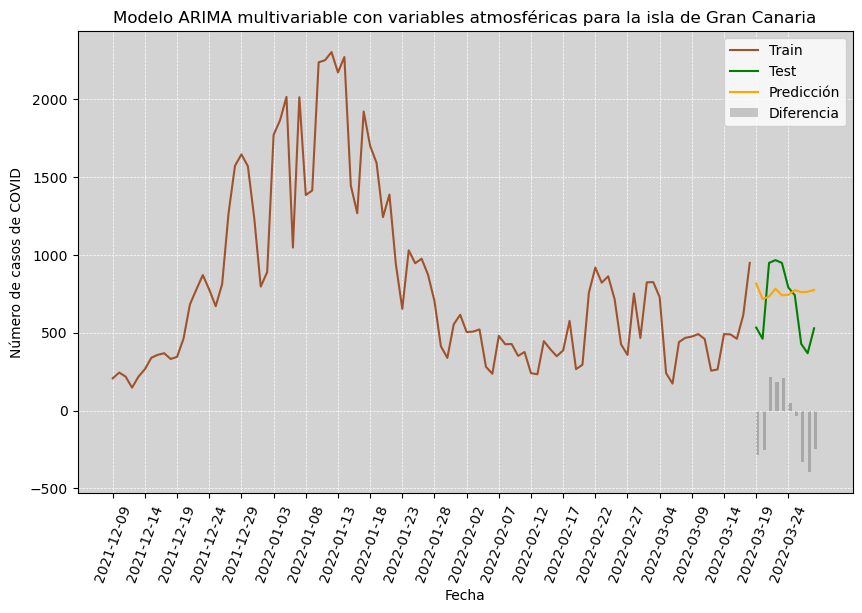

In [40]:
visualizar_historico(train, test, pred, objetivo, n_dias_train_vis, tit, color_isla, df_result['dif'])

Evaluamos los resultados con las métricas comentadas anteriormente.

In [41]:
mae, mse, rmse = obtener_errores(test[objetivo], pred)

print("Error cuadrático medio (MSE) del modelo: " + str(mse))
print("Error absoluto medio (MAE) del modelo: " + str(mae))
print("Raíz del error cuadrático medio (RMSE) del modelo: " + str(rmse))

Error cuadrático medio (MSE) del modelo: 59907.13409031518
Error absoluto medio (MAE) del modelo: 219.89021482626012
Raíz del error cuadrático medio (RMSE) del modelo: 244.75933912787715


# Modelo ARIMA multivariable con todas las variables

Realizamos el análisis unificando los datos tanto pandémicos como atmosféricos.

Dividimos los datos en conjunto de entrenamiento y test. Para el conjunto de datos de test se emplean los últimos 10 días de la serie temporal y para el conjunto de entrenamiento el resto de datos.

In [42]:
train = datos_GranCanaria_arima_total.iloc[:len(datos_GranCanaria_arima_total) - n_dias]
test =  datos_GranCanaria_arima_total.iloc[len(datos_GranCanaria_arima_total) - n_dias:]

Entrenamos el modelo con los parámetros óptimos obtenidos.

In [43]:
arima_GranCanaria = ARIMA(endog=train[objetivo],exog=train[variables], order=(p, d, q), freq = 'D')
modelo_arima_GranCanaria = arima_GranCanaria.fit()

C:\Users\jalon\anaconda3\envs\tfm\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\jalon\anaconda3\envs\tfm\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\jalon\anaconda3\envs\tfm\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\jalon\anaconda3\envs\tfm\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Visualizamos los resultados de los criterios BIC y AIC.

In [44]:
visualizar_bic_aic(modelo_arima_GranCanaria)

BIC del modelo ARIMA: 5254.969087732623
AIC del modelo ARIMA: 5201.811504351814


Evaluamos los residuos del modelo con la función de autocorrelación.

<Figure size 1600x1000 with 0 Axes>

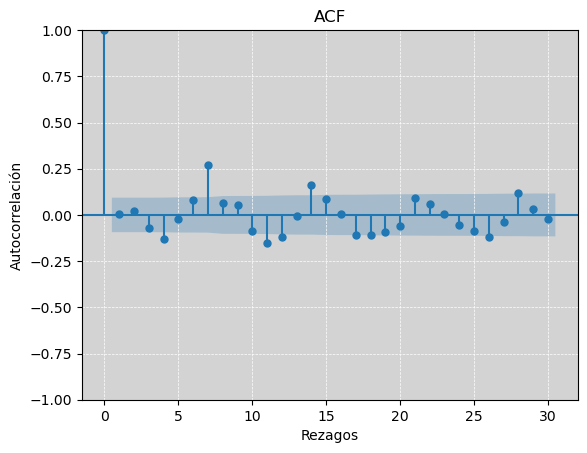

In [45]:
visualizar_acf(modelo_arima_GranCanaria.resid, 30)

Realizamos la predicción de las 10 últimas fechas de la serie temporal.

In [46]:
pred = modelo_arima_GranCanaria.forecast(steps=10, exog=test[variables])

Visualizamos una comparación entre los valores reales y los valores predichos.

In [47]:
visualizar_resultados_texto(test, pred, objetivo)

2022-03-19: número de casos reales 533, número de casos predichos 718.4665013465557
2022-03-20: número de casos reales 461, número de casos predichos 619.6446371396794
2022-03-21: número de casos reales 948, número de casos predichos 913.5377616622135
2022-03-22: número de casos reales 966, número de casos predichos 955.1475067098811
2022-03-23: número de casos reales 948, número de casos predichos 923.1874757948126
2022-03-24: número de casos reales 790, número de casos predichos 781.0686200339459
2022-03-25: número de casos reales 741, número de casos predichos 833.4588555044198
2022-03-26: número de casos reales 428, número de casos predichos 693.5381894755177
2022-03-27: número de casos reales 368, número de casos predichos 597.1702863650987
2022-03-28: número de casos reales 528, número de casos predichos 760.845965603455


C:\Users\jalon\AppData\Local\Temp\ipykernel_7056\4176007000.py:174: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  valor_test = y_test[variable][i]
C:\Users\jalon\AppData\Local\Temp\ipykernel_7056\4176007000.py:177: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(str(fechas[i]) + ': número de casos reales ' + str(valor_test) + ', número de casos predichos ' + str(y_pred[i]))


Graficamos la diferencia entre los valores de test y los predichos.

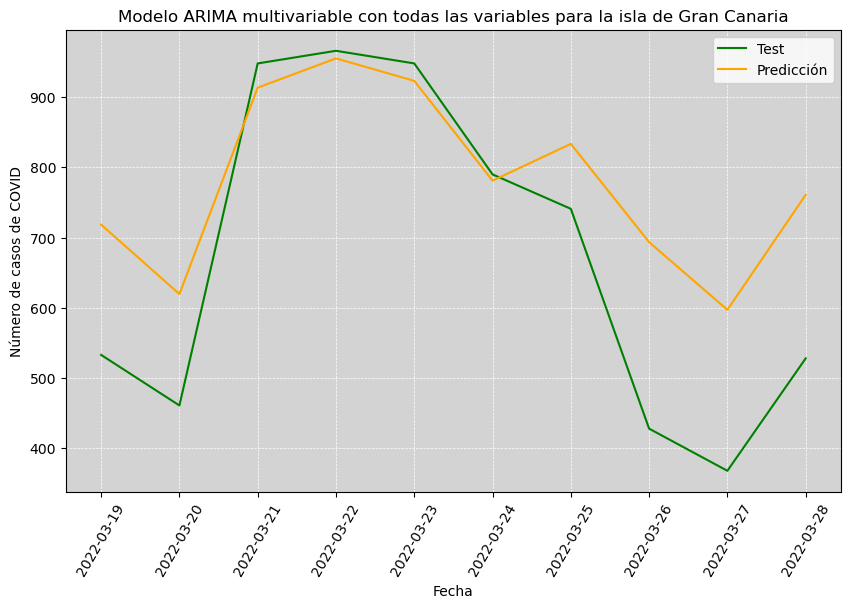

In [48]:
tit = 'Modelo ARIMA multivariable con todas las variables para la isla de ' + isla

visualizar_dif_pred_test(test, pred, objetivo, tit)

Calculamos la diferencia entre los valores reales y los valores predichos.

In [49]:
df_result = obtener_df_diferencias(test, pred, objetivo)
df_result

C:\Users\jalon\AppData\Local\Temp\ipykernel_7056\4176007000.py:197: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df_result.iloc[i, df_result.columns.get_loc('pred')] = pred[i]
C:\Users\jalon\AppData\Local\Temp\ipykernel_7056\4176007000.py:197: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '718.4665013465557' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_result.iloc[i, df_result.columns.get_loc('pred')] = pred[i]
C:\Users\jalon\AppData\Local\Temp\ipykernel_7056\4176007000.py:198: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value 

,numero_casos,pred,dif
fecha,,,
2022-03-19,533,718.466501,-185.466501
2022-03-20,461,619.644637,-158.644637
2022-03-21,948,913.537762,34.462238
2022-03-22,966,955.147507,10.852493
2022-03-23,948,923.187476,24.812524
2022-03-24,790,781.068620,8.931380
2022-03-25,741,833.458856,-92.458856
2022-03-26,428,693.538189,-265.538189
2022-03-27,368,597.170286,-229.170286


Por último, graficamos una parte del histórico de los datos de entrenamiento junto con los resultados del modelo ARIMA y los valores predichos. A su vez mostramos un histograma con la diferencia entre dichos valores.

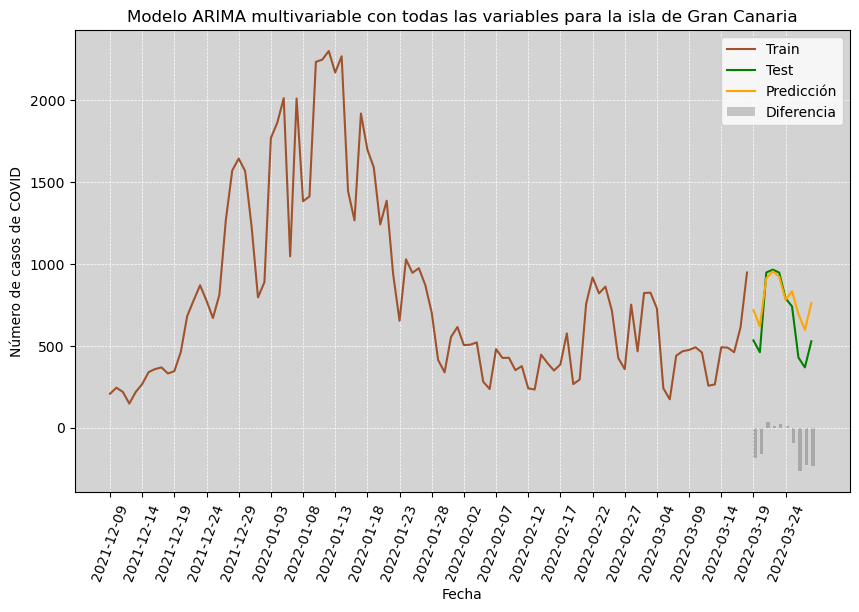

In [50]:
visualizar_historico(train, test, pred, objetivo, n_dias_train_vis, tit, color_isla, df_result['dif'])

In [51]:
mae, mse, rmse = obtener_errores(test[objetivo], pred)

print("Error cuadrático medio (MSE) del modelo: " + str(mse))
print("Error absoluto medio (MAE) del modelo: " + str(mae))
print("Raíz del error cuadrático medio (RMSE) del modelo: " + str(rmse))

Error cuadrático medio (MSE) del modelo: 24736.22312838959
Error absoluto medio (MAE) del modelo: 124.31830712338733
Raíz del error cuadrático medio (RMSE) del modelo: 157.27753535832633
